> **Data Source & Course Notice**
> This notebook was developed as part of the **IBM Developer Skills Network / Coursera: "Data Analysis with Python"** course practice lab.  
> The lab materials and datasets are publicly accessible via IBM Skills Network and are used **for educational purposes**.  
> All analysis and code written in this notebook are **my own work**.  
> This file does **not** contain any autograder cells, hidden tests, or proprietary Coursera content.


**Hands-on Practice Lab: Model Evaluation and Refinement**

In [7]:
# Setup
!pip install seaborn tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures


In [9]:
import requests

def download(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print("Download failed with status:", response.status_code)


In [10]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/laptop_pricing_dataset_mod2.csv'

In [12]:
download(filepath, "laptops.csv")
file_name = "laptops.csv"

Downloaded: laptops.csv


In [13]:
df = pd.read_csv(file_name, header=0)

In [14]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,0,0,Acer,4,2,1,5,14.0,0.551724,8,256,3.52800,978,Low,0,1
1,1,1,Dell,3,1,1,3,15.6,0.689655,4,256,4.85100,634,Low,1,0
2,2,2,Dell,3,1,1,7,15.6,0.931034,8,256,4.85100,946,Low,1,0
3,3,3,Dell,4,2,1,5,13.3,0.551724,8,128,2.69010,1244,Low,0,1
4,4,4,HP,4,2,1,7,15.6,0.620690,8,256,4.21155,837,Low,1,0


In [15]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [17]:
# Task 1 : Using Cross validation to improve the model
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = x_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = x_data.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

preprocess = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

lin_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

Rcross_all = cross_val_score(lin_pipe, x_data, y_data, cv=4, scoring="r2")
print("CV (ALL FEATURES via Pipeline) -> mean R^2:", Rcross_all.mean(), " std:", Rcross_all.std())


Numeric: ['Category', 'GPU', 'OS', 'CPU_core', 'Screen_Size_inch', 'CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'Weight_pounds', 'Screen-Full_HD', 'Screen-IPS_panel']
Categorical: ['Manufacturer', 'Price-binned']
CV (ALL FEATURES via Pipeline) -> mean R^2: 0.7714903244959768  std: 0.10184584457509956


In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

assert 'CPU_frequency' in x_data.columns, "CPU_frequency sütunu yok!"
X_tr, X_te, y_tr, y_te = train_test_split(
    x_data[['CPU_frequency']], y_data, test_size=0.5, random_state=0
)

orders = [1,2,3,4,5]
r2_train, r2_test = [], []

for d in orders:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    pipe = Pipeline([
        ("poly", poly),
        ("scale", StandardScaler(with_mean=False)),
        ("lin", LinearRegression())
    ])
    pipe.fit(X_tr, y_tr)
    r2_train.append(pipe.score(X_tr, y_tr))
    r2_test.append(pipe.score(X_te, y_te))

print("Train R^2:", [round(v,4) for v in r2_train])
print("Test  R^2:", [round(v,4) for v in r2_test])


Train R^2: [0.1678, 0.3701, 0.3755, 0.4039, 0.4173]
Test  R^2: [0.0532, -0.0269, 0.0516, -0.9948, -1.3759]


Best test R^2: 0.8218872910603816  at alpha = 0.233


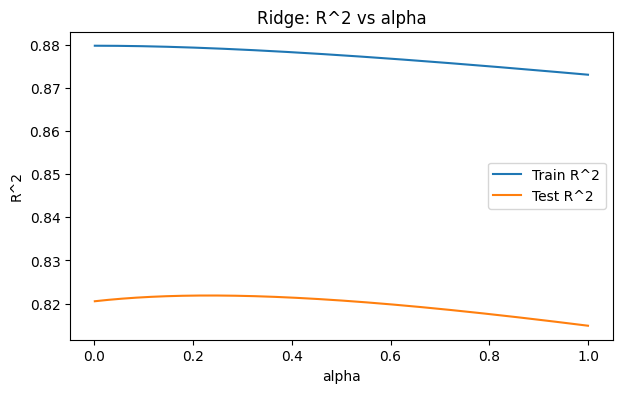

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X_tr, X_te, y_tr, y_te = train_test_split(x_data, y_data, test_size=0.5, random_state=0)

ridge_pipe = Pipeline([
    ("preprocess", preprocess),
    ("ridge", Ridge())
])

alphas = np.arange(0.001, 1.001, 0.001)
r2_tr_list, r2_te_list = [], []

for a in alphas:
    ridge_pipe.set_params(ridge__alpha=a)
    ridge_pipe.fit(X_tr, y_tr)
    r2_tr_list.append(ridge_pipe.score(X_tr, y_tr))
    r2_te_list.append(ridge_pipe.score(X_te, y_te))

best_idx = int(np.argmax(r2_te_list))
print("Best test R^2:", r2_te_list[best_idx], " at alpha =", float(alphas[best_idx]))

plt.figure(figsize=(7,4))
plt.plot(alphas, r2_tr_list, label="Train R^2")
plt.plot(alphas, r2_te_list, label="Test R^2")
plt.xlabel("alpha"); plt.ylabel("R^2"); plt.legend(); plt.title("Ridge: R^2 vs alpha")
plt.show()


In [25]:
if 'CPU_frequency' in x_data.columns:
    Rcross = cross_val_score(lre, x_data[['CPU_frequency']], y_data, cv=4)
    print("4-fold CV R^2 (CPU_frequency): mean =", Rcross.mean(), " std =", Rcross.std())


4-fold CV R^2 (CPU_frequency): mean = -0.16109232388595113  std = 0.384957978666471


Orders: [1, 2, 3, 4, 5]
R^2 train: [0.1678, 0.3701, 0.3755, 0.4039, 0.4173]
R^2 test : [0.0532, -0.0269, 0.0516, -0.9948, -1.3759]


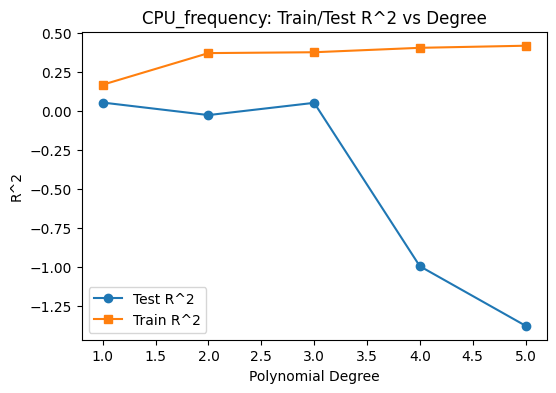

In [26]:
# Task 2: Overfitting
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.5, random_state=0
)

assert 'CPU_frequency' in x_train.columns, "CPU_frequency sütunu bulunamadı."

orders = list(range(1, 6))
Rsqu_test = []
Rsqu_train = []

for d in orders:
    pr = PolynomialFeatures(degree=d, include_bias=False)
    Xtr = pr.fit_transform(x_train[['CPU_frequency']])
    Xte = pr.transform(x_test[['CPU_frequency']])

    lm = LinearRegression().fit(Xtr, y_train)
    Rsqu_train.append(lm.score(Xtr, y_train))
    Rsqu_test.append(lm.score(Xte, y_test))

print("Orders:", orders)
print("R^2 train:", [round(v, 4) for v in Rsqu_train])
print("R^2 test :", [round(v, 4) for v in Rsqu_test])

plt.figure(figsize=(6,4))
plt.plot(orders, Rsqu_test, marker='o', label='Test R^2')
plt.plot(orders, Rsqu_train, marker='s', label='Train R^2')
plt.xlabel("Polynomial Degree")
plt.ylabel("R^2")
plt.title("CPU_frequency: Train/Test R^2 vs Degree")
plt.legend()
plt.show()


Max test R^2: 0.3561018938287065  at alpha= 0.001


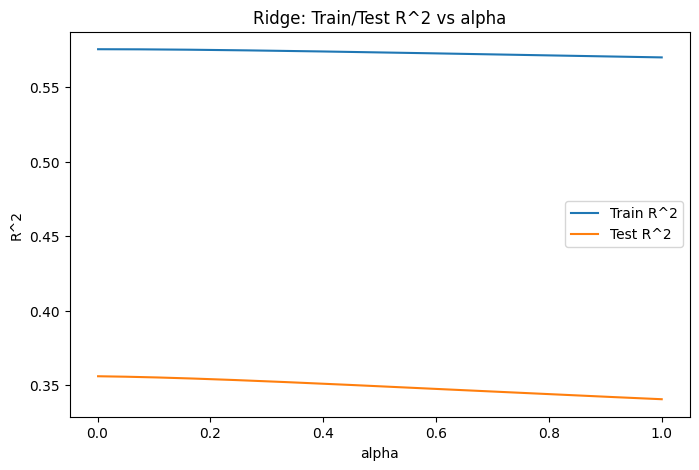

In [27]:
# Task 3 : Ridge Regression
feat_list = ['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']
missing = [c for c in feat_list if c not in x_data.columns]
if missing:
    raise ValueError(f"Beklenen sütun(lar) yok: {missing}")

Xtr = x_train[feat_list].values
Xte = x_test[feat_list].values

alphas = np.arange(0.001, 1.001, 0.001)
r2_train_list = []
r2_test_list  = []

for a in alphas:
    rr = Ridge(alpha=a).fit(Xtr, y_train)
    r2_train_list.append(rr.score(Xtr, y_train))
    r2_test_list.append(rr.score(Xte, y_test))

print("Max test R^2:", max(r2_test_list), " at alpha=", float(alphas[int(np.argmax(r2_test_list))]))

plt.figure(figsize=(8,5))
plt.plot(alphas, r2_train_list, label="Train R^2")
plt.plot(alphas, r2_test_list, label="Test R^2")
plt.xlabel("alpha")
plt.ylabel("R^2")
plt.title("Ridge: Train/Test R^2 vs alpha")
plt.legend()
plt.show()


In [29]:
# Task 4: Grid Search
parameters1 = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

grid = GridSearchCV(Ridge(), parameters1, cv=4, scoring='r2', n_jobs=-1)
grid.fit(x_train[feat_list], y_train)

print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)

BestRR = grid.best_estimator_
print("Test R^2 (best ridge):", BestRR.score(x_test[feat_list], y_test))


Best params: {'alpha': 10}
Best CV R^2: 0.4695769038120168
Test R^2 (best ridge): 0.300990504869182
